# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [8]:
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%matplotlib inline
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from state_inference.gridworld_env import CnnWrapper, ThreadTheNeedleEnv
from state_inference.utils.training_utils import parse_task_config
from state_inference.utils.pytorch_utils import DEVICE
from state_inference.model.agents import ViAgentWithExploration
from state_inference.model.vae import Encoder, Decoder, StateVae
from state_inference.utils.training_utils import load_config

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.11 (main, Apr 20 2023, 13:58:42) [Clang 14.0.6 ]
torch 2.0.1
device = mps


In [10]:
TASK_CONFIG_FILE = "state_inference/env_config.yml"
TASK_NAME = "thread_the_needle"
TASK_CLASS = ThreadTheNeedleEnv

MODEL_CONFIG_FILE = "state_inference/model/model_config.yml"

In [11]:
env_kwargs, training_kwargs = parse_task_config(TASK_NAME, TASK_CONFIG_FILE)

training_kwargs["n_train_steps"] = 50000
training_kwargs["n_epochs"] = 1

# create the task
task = CnnWrapper(TASK_CLASS.create_env(**env_kwargs))

pi, _ = task.get_optimal_policy()
training_kwargs["optimal_policy"] = pi

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
### Model + Training Parameters

model_config = load_config(MODEL_CONFIG_FILE)

# N_EPOCHS = 20  # should be 20
EMBEDDING_LAYERS = 5
EMBEDDING_DIM = len(task.observation_model.states) // 2
OBSERVATION_DIM = task.observation_model.map_height**2
# LR = 3e-4
# beta = 1.0
# tau = 2.0
# gamma = 0.99
# dropout = 0.0

# optim_kwargs = dict(lr=LR)

# create the model
encoder_hidden = [OBSERVATION_DIM // 5, OBSERVATION_DIM // 10]
decoder_hidden = [OBSERVATION_DIM // 10, OBSERVATION_DIM // 5]
z_dim = EMBEDDING_DIM * EMBEDDING_LAYERS


def make_model():
    encoder = Encoder(
        OBSERVATION_DIM,
        encoder_hidden,
        z_dim,
    )

    decoder = Decoder(
        z_dim,
        decoder_hidden,
        OBSERVATION_DIM,
    )

    vae_kwargs = model_config["vae_kwargs"]
    vae_kwargs.update(dict(z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS))

    vae_model = StateVae(encoder, decoder, **vae_kwargs).to(DEVICE)

    agent = ViAgentWithExploration(
        task,
        vae_model,
        set_action=set(range(4)),
        **model_config["state_inference_model"],
    )
    return agent

In [34]:
agent = make_model()
print(agent.state_inference_model)
agent.learn(30000, estimate_batch=True, progress_bar=True)

StateVae(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=1600, out_features=320, bias=True)
      (1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=320, out_features=160, bias=True)
      (5): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.0, inplace=False)
      (7): ReLU()
      (8): Linear(in_features=160, out_features=1000, bias=True)
      (9): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=1000, out_features=160, bias=True)
      (1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.01, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=160, out_features=320, bias=True)
      (5): BatchNorm

100%|██████████| 30000/30000 [04:53<00:00, 102.08it/s]


In [46]:
from state_inference.utils.training_utils import get_policy_prob, vae_get_pmf

pmf = get_policy_prob(
    agent,
    vae_get_pmf,
    n_states=env_kwargs["n_states"],
    map_height=env_kwargs["map_height"],
    cnn=True,
)
pmf

array([[0.03649844, 0.7121012 , 0.03505173, 0.21634863],
       [0.03649844, 0.7121012 , 0.03505173, 0.21634863],
       [0.04319909, 0.8851823 , 0.06816198, 0.00345662],
       ...,
       [0.47826476, 0.03838041, 0.44497441, 0.03838041],
       [0.47826476, 0.03838041, 0.44497441, 0.03838041],
       [0.47826476, 0.03838041, 0.44497441, 0.03838041]])

Text(0.5, 0.98, 'Value Iteration Agent Learned Policy')

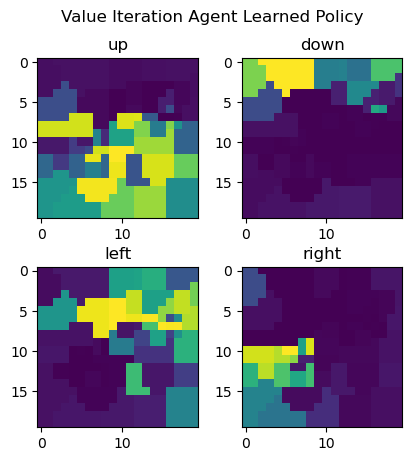

In [47]:
import seaborn as sns

fig, axes = plt.subplots(2, 2)
h, w = env_kwargs["height"], env_kwargs["width"]

axes[0][0].imshow(pmf[:, 0].reshape(h, w))
axes[0][1].imshow(pmf[:, 1].reshape(h, w))
axes[1][0].imshow(pmf[:, 2].reshape(h, w))
axes[1][1].imshow(pmf[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("Value Iteration Agent Learned Policy")

In [48]:
np.sum(pi * pmf, axis=1).mean()

0.6848699940216189

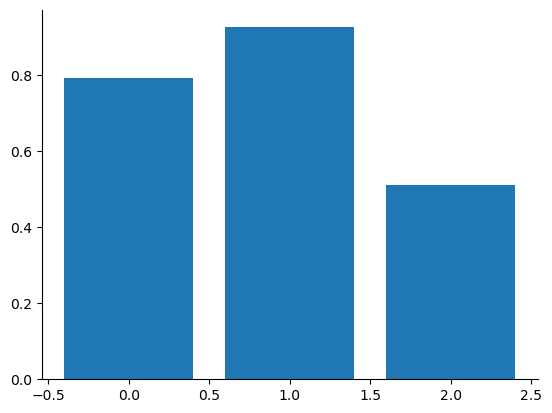

In [49]:
room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10

score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()
plt.bar([0, 1, 2], [score_room_1, score_room_2, score_room_3])

sns.despine()

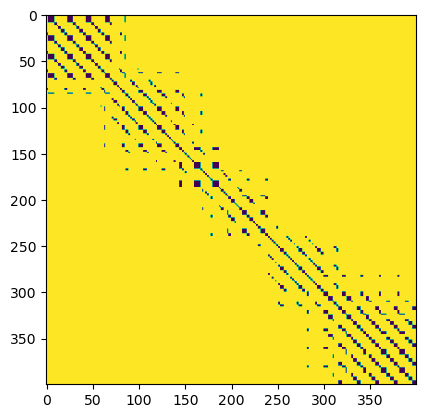

In [50]:
from state_inference.utils.pytorch_utils import make_tensor, convert_8bit_to_float
from sklearn.metrics import pairwise_distances

obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)
d = pairwise_distances(z.reshape(-1, 1), metric=lambda x, y: x == y)
plt.imshow(1 - d)

<Axes: title={'center': 'Thread-the-needle states'}>

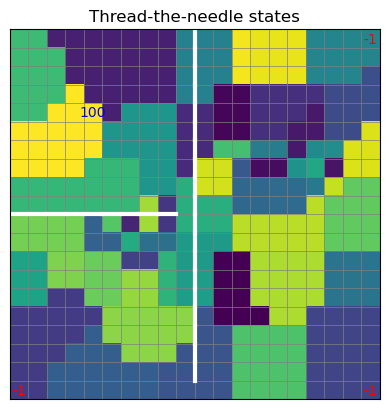

In [51]:
# plot the overlap of different states
# number the states and plot them
clusters = {}
k = 0
for z0 in sorted(z):
    if z0 not in clusters.keys():
        clusters[z0] = k
        k += 1
clustered_states = np.array([clusters[z0] for z0 in z])
plt.imshow(clustered_states.reshape(-1, 20))
task.display_gridworld(plt.gca(), wall_color="w")

In [52]:
euc = pairwise_distances(
    [(x, y) for x in range(20) for y in range(20)],
    # metric=lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2),
    metric=lambda x, y: np.abs(x[0] - y[0]) + np.abs(x[1] - y[1]),
)

d_w_wall = np.mean([d[s1][s2] for s1, s2 in task.transition_model.walls])
print(f"Distance between neighboring states sepearted by a wall     {d_w_wall}")


wall_mask = np.zeros((task.n_states, task.n_states))
for s0, s1 in task.transition_model.walls:
    wall_mask[s0][s1] = 1.0
    wall_mask[s1][s0] = 1.0


d_wo_wall = d.reshape(-1)[(wall_mask.reshape(-1) == 0) & (euc.reshape(-1) == 1)].mean()
print(f"Distance between neighboring states NOT sepearted by a wall {d_wo_wall}")

Distance between neighboring states sepearted by a wall     0.6071428571428571
Distance between neighboring states NOT sepearted by a wall 0.6557377049180327


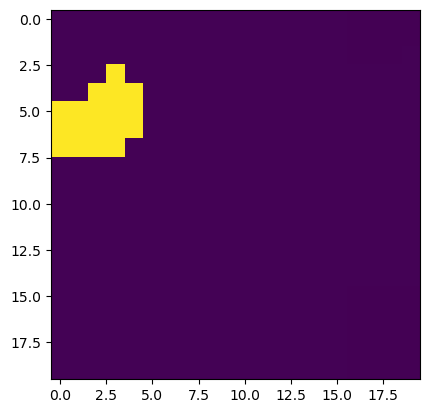

In [53]:
# agent._estimate_reward_model()

rews = np.array([agent.reward_estimator.get_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

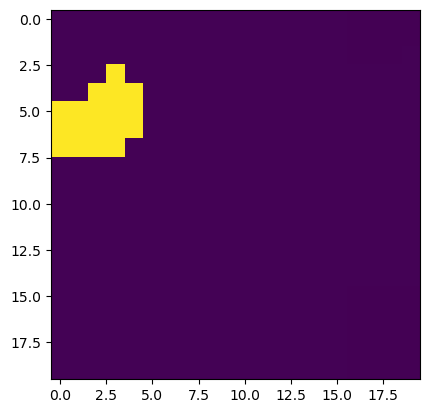

In [54]:
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)

rews = np.array([agent.reward_estimator.get_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

Text(0.5, 1.0, 'Learned Value function')

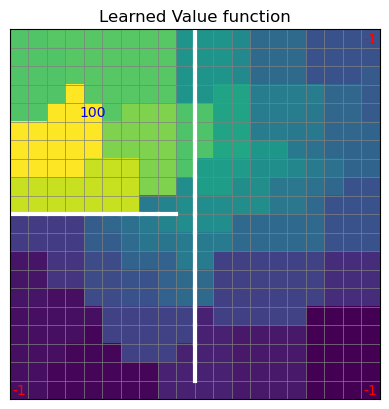

In [55]:
def get_value_function(model, task):
    obs = convert_8bit_to_float(
        torch.stack(
            [
                make_tensor(task.observation_model(s))
                for s in range(task.transition_model.n_states)
                for _ in range(1)
            ]
        )
    ).to(DEVICE)
    z = model.state_inference_model.get_state(obs)

    hash_vector = np.array(
        [
            model.state_inference_model.z_dim**ii
            for ii in range(agent.state_inference_model.z_layers)
        ]
    )

    z = z.dot(hash_vector)

    value_function = np.array(
        [agent.value_function.get(z0, np.nan) for z0 in z]
    ).reshape(20, 20)
    return value_function


v = get_value_function(agent, task)
plt.imshow(v)
task.display_gridworld(plt.gca(), wall_color="w", annotate=True)
plt.title("Learned Value function")

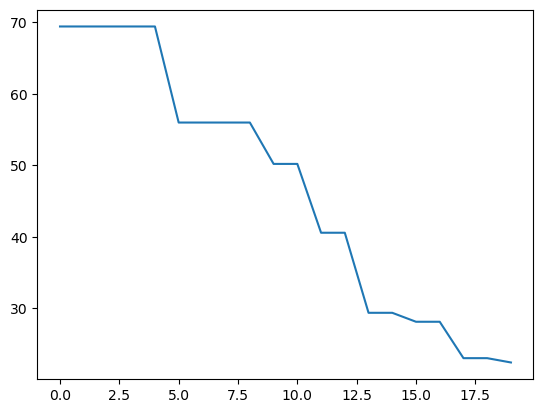

In [56]:
plt.plot(v[5] - np.nanmin(v))

In [19]:
from tqdm import trange


## Repeat with iterations
n_models = 15
# n_models=4


room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10


scores = []
value_functions = []


for idx in trange(n_models):
    agent = make_model()
    agent.learn(total_timesteps=training_kwargs["n_train_steps"], progress_bar=False)
    #     agent.learn(total_timesteps=500, progress_bar=False)

    pmf = get_policy_prob(
        agent,
        vae_get_pmf,
        n_states=env_kwargs["n_states"],
        map_height=env_kwargs["map_height"],
        cnn=True,
    )

    score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
    score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
    score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

    v = get_value_function(agent, task)

    scores.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * 4,
                "Score": [
                    np.sum(pi * pmf, axis=1).mean(),
                    score_room_1,
                    score_room_2,
                    score_room_3,
                ],
                "Condition": ["Overall", "Room 1", "Room 2", "Room 3"],
            }
        )
    )

    value_functions.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * task.n_states,
                "State-Values": v.reshape(-1),
                "States": np.arange(task.n_states),
            }
        )
    )

scores = pd.concat(scores)
value_functions = pd.concat(value_functions)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [3:09:14<00:00, 756.94s/it]


Text(0.5, 1.0, 'Learned Value function')

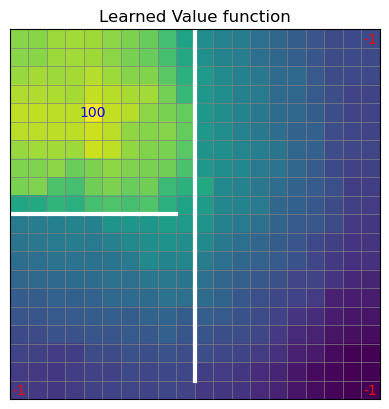

In [65]:
# Plot the average value function (n)

# normalize the value function between zero and one within each iteration
from sklearn.preprocessing import MinMaxScaler


def min_max_scale(grouped_data):
    v = grouped_data["State-Values"].values.reshape(-1, 1)
    v = MinMaxScaler().fit_transform(grouped_data["State-Values"].values.reshape(-1, 1))
    grouped_data["State-Values"] = v
    return grouped_data.drop("Iteration", axis=1)


normed_vf = value_functions.groupby("Iteration", group_keys=True).apply(min_max_scale)

# average and plot
plt.imshow(x.groupby("States").mean().values.reshape(20, 20))
task.display_gridworld(plt.gca(), wall_color="w", annotate=True)
plt.title("Learned Value function")

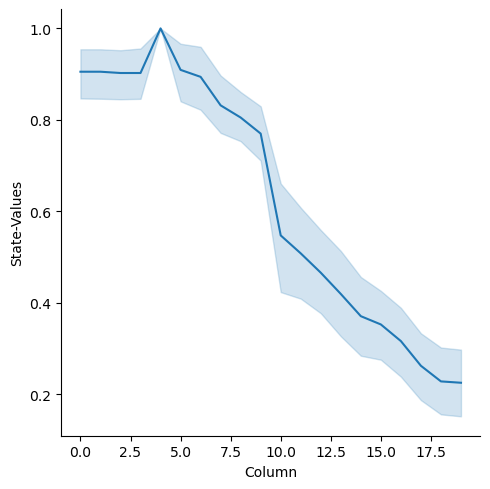

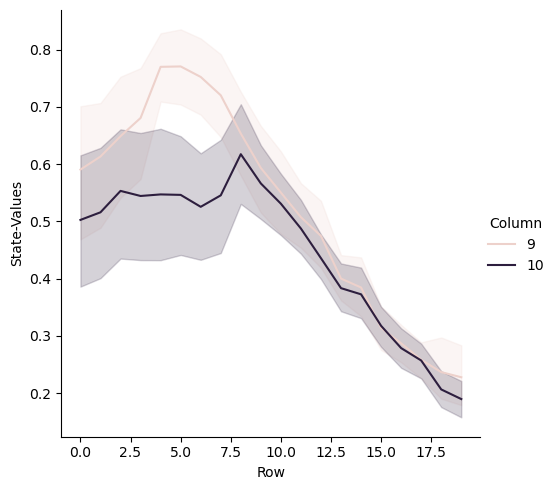

In [93]:
# plot 1d Value function through the goal
normed_vf["Row"] = normed_vf["States"] // 20
normed_vf["Column"] = normed_vf["States"] % 20

sns.relplot(
    data=normed_vf[normed_vf["Row"] == 4], x="Column", y="State-Values", kind="line"
)
sns.relplot(
    data=normed_vf[(normed_vf["Column"] >= 9) & (normed_vf["Column"] <= 10)],
    x="Row",
    y="State-Values",
    kind="line",
    hue="Column",
)

plt.imshow(
    value_functions.groupby("States")["State-Values"]
    .apply(np.nanmean)
    .values.reshape(20, 20)
)
value_functions.to_csv('value_functions_vae.csv')

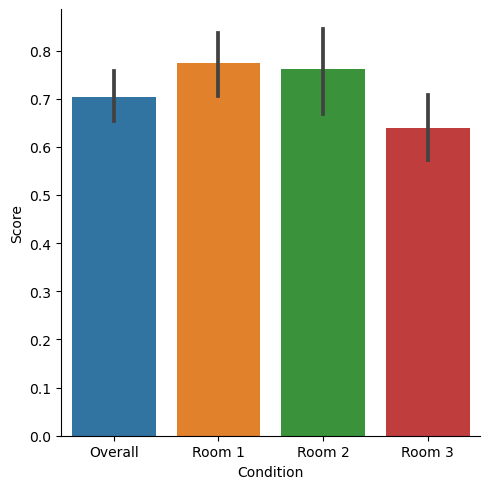

In [20]:
sns.catplot(data=scores, y="Score", x="Condition", kind="bar")

(0.0, 1.0)

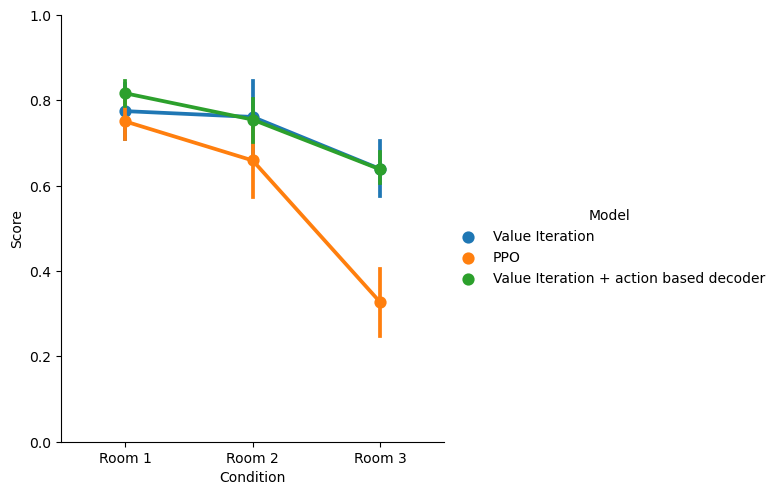

In [21]:
scores["Model"] = "Value Iteration"
scores.to_csv("sims_thread_the_needle_vi_agent_new.csv")
scores2 = pd.read_csv("sims_thread_the_needle.csv")
scores2["Model"] = "PPO"
scores3 = pd.read_csv("sims_thread_the_needle_state_inf.csv")
scores3["Model"] = "Value Iteration + action based decoder"


all_scores = pd.concat([scores, scores2, scores3])
sns.catplot(
    data=all_scores[all_scores["Condition"] != "Overall"],
    y="Score",
    x="Condition",
    kind="point",
    hue="Model",
)
plt.gca().set_ylim([0, 1])

(0.0, 1.0)

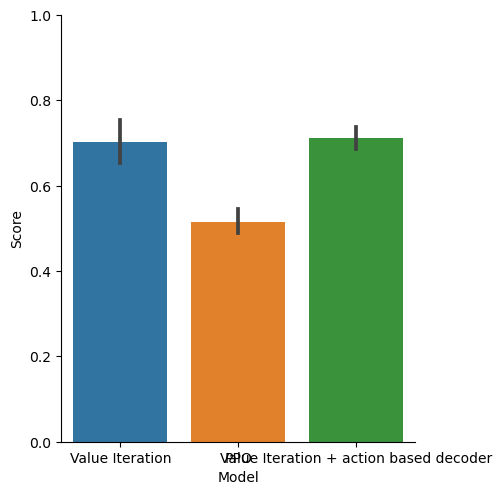

In [22]:
sns.catplot(
    data=all_scores[all_scores["Condition"] == "Overall"],
    y="Score",
    x="Model",
    kind="bar",
)
plt.gca().set_ylim([0, 1])